In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///..//Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
#  use inspector to get column names/types for measurement table
inspector = inspect(engine)

mcolumns = inspector.get_columns('measurement')
for c in mcolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
# use inspector to get column names/types for station table
scolumns = inspector.get_columns('station')
for c in scolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# get the max date in dataset 
MaxDate = engine.execute('SELECT max(date) FROM measurement order by date desc limit 1').fetchall()
for maxdate in MaxDate:
    print (f'MaxDate: {maxdate}')

# lastest date
maxDBDT = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print (f'maxDBDT: {maxDBDT}')

MaxDate: ('2017-08-23',)
maxDBDT: ('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from today
todayDT = dt.date.today()
print(f'Today: {todayDT}')

####   DIRECTION YIELDS NO RESULT.  MAX(date) in database is 2017-08-23, see section above
####   Change to use MAX(date) - 1 year

lastDBDT = dt.datetime(2017, 8,23)
print (f'lastDBDT: {lastDBDT}')

#yearAgoDT = dt.datetime(todayDT - dt.timedelta(days=365))
yearAgoDT = lastDBDT- dt.timedelta(days=365)
print (f'A year ago: {yearAgoDT}')


# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date,Measurement.prcp ]

#lastYearPrec = session.query(*sel).filter(Measurement.date >= yearAgoDT).\
#               filter(Measurement.date <= lastDBDT).order_by(Measurement.date).all()

lastYearPrec = session.query(*sel).filter(Measurement.date >= yearAgoDT).\
               filter(Measurement.date <= lastDBDT).order_by(Measurement.date).limit(50).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(lastYearPrec, columns=['date', 'prcp'])
df.head()

# Sort the dataframe by date
df.set_index('date', inplace=True)
df.sort_values('date')


# Use Pandas Plotting with Matplotlib to plot the data
#df.plot.bar(figsize=(10, 30), rot=90)
#plt.tight_layout()
#plt.show()

# Rotate the xticks for the dates


Today: 2018-09-05
lastDBDT: 2017-08-23 00:00:00
A year ago: 2016-08-23 00:00:00


,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22
2016-08-24,2.15
2016-08-24,1.45
2016-08-25,0.11
2016-08-25,0.06


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,45.000000
mean,0.342222
std,0.651090
min,0.000000
25%,0.000000
50%,0.080000
75%,0.180000
max,2.280000


In [15]:
# How many stations are available in this dataset?
stations =  session.query(Measurement).group_by(Measurement.station).count()
print (stations)

9


In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
#stationCounts =  session.query(Measurement).group_by(Measurement.station).all()
stationCounts = engine.execute('SELECT station, count(*) AS station_cnt FROM measurement group by station order by count(*) desc').fetchall()

print (stationCounts)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

activesel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

activeStationStat = session.query(*activesel).filter(Measurement.station == "USC00519281").all()
activeStationStat

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tempsel = [Measurement.date, Measurement.tobs ]

lastYearPrec = session.query(*tempsel).filter(Measurement.date >= yearAgoDT).\
               filter(Measurement.station == "USC00519281").\
               filter(Measurement.date <= lastDBDT).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
#df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
activeTobs_df = pd.DataFrame(lastYearPrec, columns=['date', 'tobs'])
activeTobs_df.head()


,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


<IPython.core.display.Javascript object>


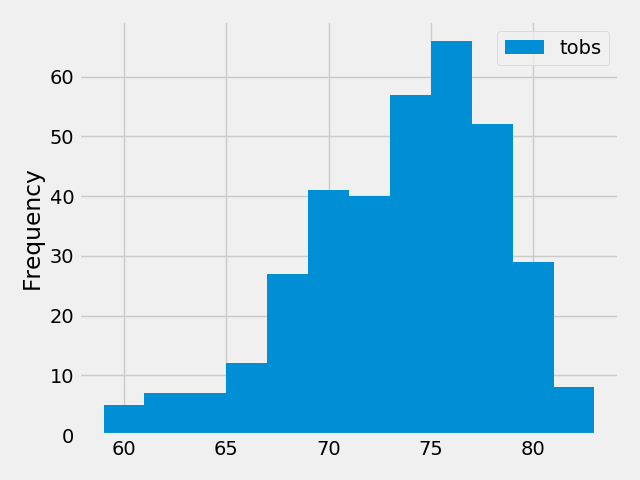

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

activeTobs_df.plot.hist(bins=12)
plt.tight_layout()
plt.show()